In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [197]:
import pickle
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt

import utils

In [95]:
save_image = True

## Apply Camera Calibration

In [3]:
with open("./output_data/camera_calibration.p", 'rb') as f:
    calibration = pickle.load(f)
    
mtx, dist = calibration["mtx"], calibration["dist"]

def gen_load_undistort_func(mtx, dist):
    def func(img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img_udist = cv2.undistort(img, mtx, dist, None, mtx)
        return img_udist
    return func

load_undistort_img = gen_load_undistort_func(mtx, dist)

In [108]:
# load original image
img = cv2.cvtColor(cv2.imread("test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)

print(img.shape)

(720, 1280, 3)


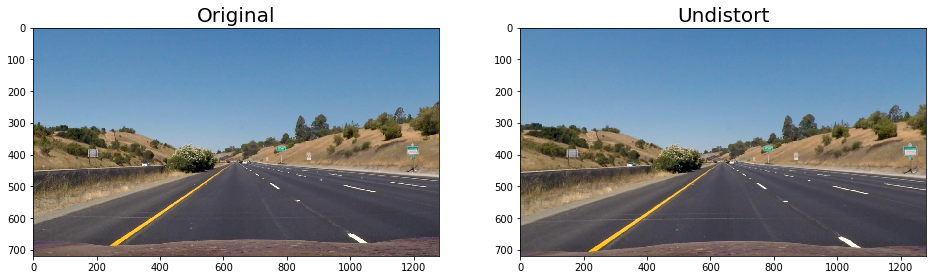

In [98]:


#img_udist = cv2.undistort(img, mtx, dist, None, mtx)
img_undistort = load_undistort_img("test_images/straight_lines1.jpg")
plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Original", fontsize=20)
plt.imshow(img)
ax = plt.subplot(1, 2, 2)
ax.set_title("Undistort", fontsize=20)
plt.imshow(img_undistort)


if save_image:
    plt.savefig("./output_images/undistort.png", bbox_inches="tight")

### Perspective transformation

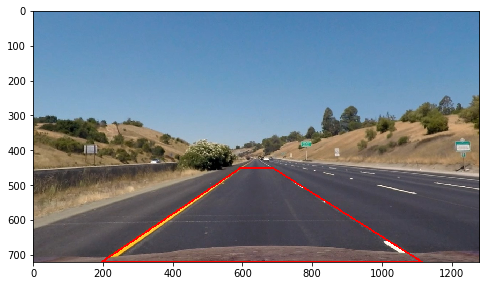

In [148]:
img = img_undistort.copy()
src_points = [(595, 450), (685, 450), (1115, 720),(195, 720)]
color=[255, 0, 0]
thickness = 4

## draw rectangular region
for i in range(4):
    cv2.line(img, src_points[i-1], src_points[i], color, thickness)


plt.figure(figsize=(8, 5))
plt.imshow(img)


if save_image:
    plt.savefig("./output_images/perspective_original.png", bbox_inches="tight")

In [138]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_data/camera_calibration.p", "wb" ) )

In [139]:
M, M_inv, dst = utils.make_warp_matrix(img_undistort, src_points)
warp_pickle = {}
warp_pickle["M"] = M
warp_pickle["M_inv"] = M_inv
pickle.dump(warp_pickle, open( "output_data/warp_matrix.p", "wb" ) )

In [149]:
dst

array([[ 300.,  100.],
       [ 980.,  100.],
       [ 980.,  720.],
       [ 300.,  720.]], dtype=float32)

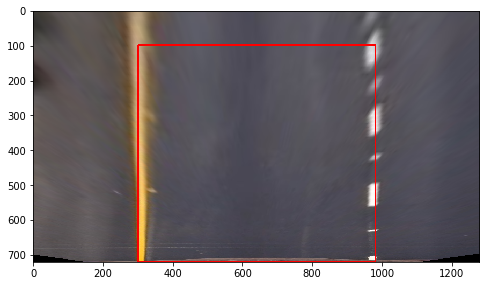

In [147]:
warped = utils.warp_img(img_undistort, M)
for i in range(4):    
    cv2.line(warped, tuple(dst[i-1]), tuple(dst[i]), color, thickness)

plt.figure(figsize=(8, 5))
plt.imshow(warped)

if save_image:
    plt.savefig("./output_images/perspective_result.png", bbox_inches="tight")

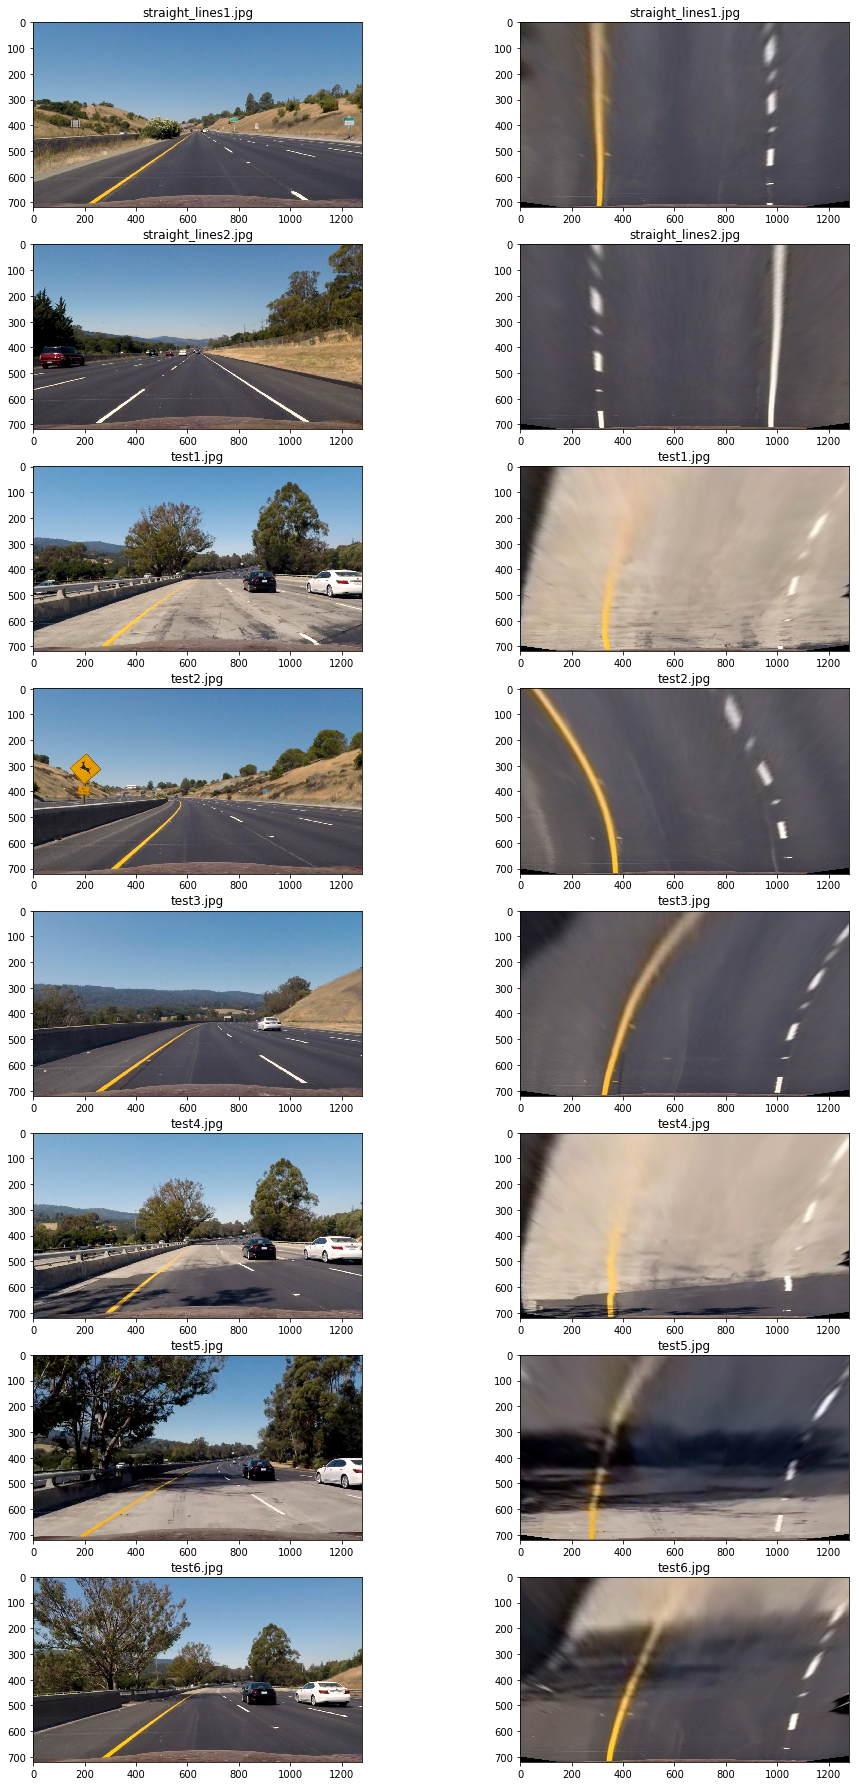

In [116]:
img_tests = glob.glob("./test_images/*.jpg")

n = len(img_tests)

plt.figure(figsize=(16, 32))
for i, img_path in enumerate(img_tests):
    
    img = load_undistort_img(img_path)
    warped = utils.warp_img(img, M)
    ax = plt.subplot(n, 2, 2*i + 1)
    ax.set_title("{0}".format(Path(img_path).name))
    plt.imshow(img)
    
    ax = plt.subplot(n, 2, 2*i + 2)
    ax.set_title("{0}".format(Path(img_path).name))
    plt.imshow(warped)

## Binalization



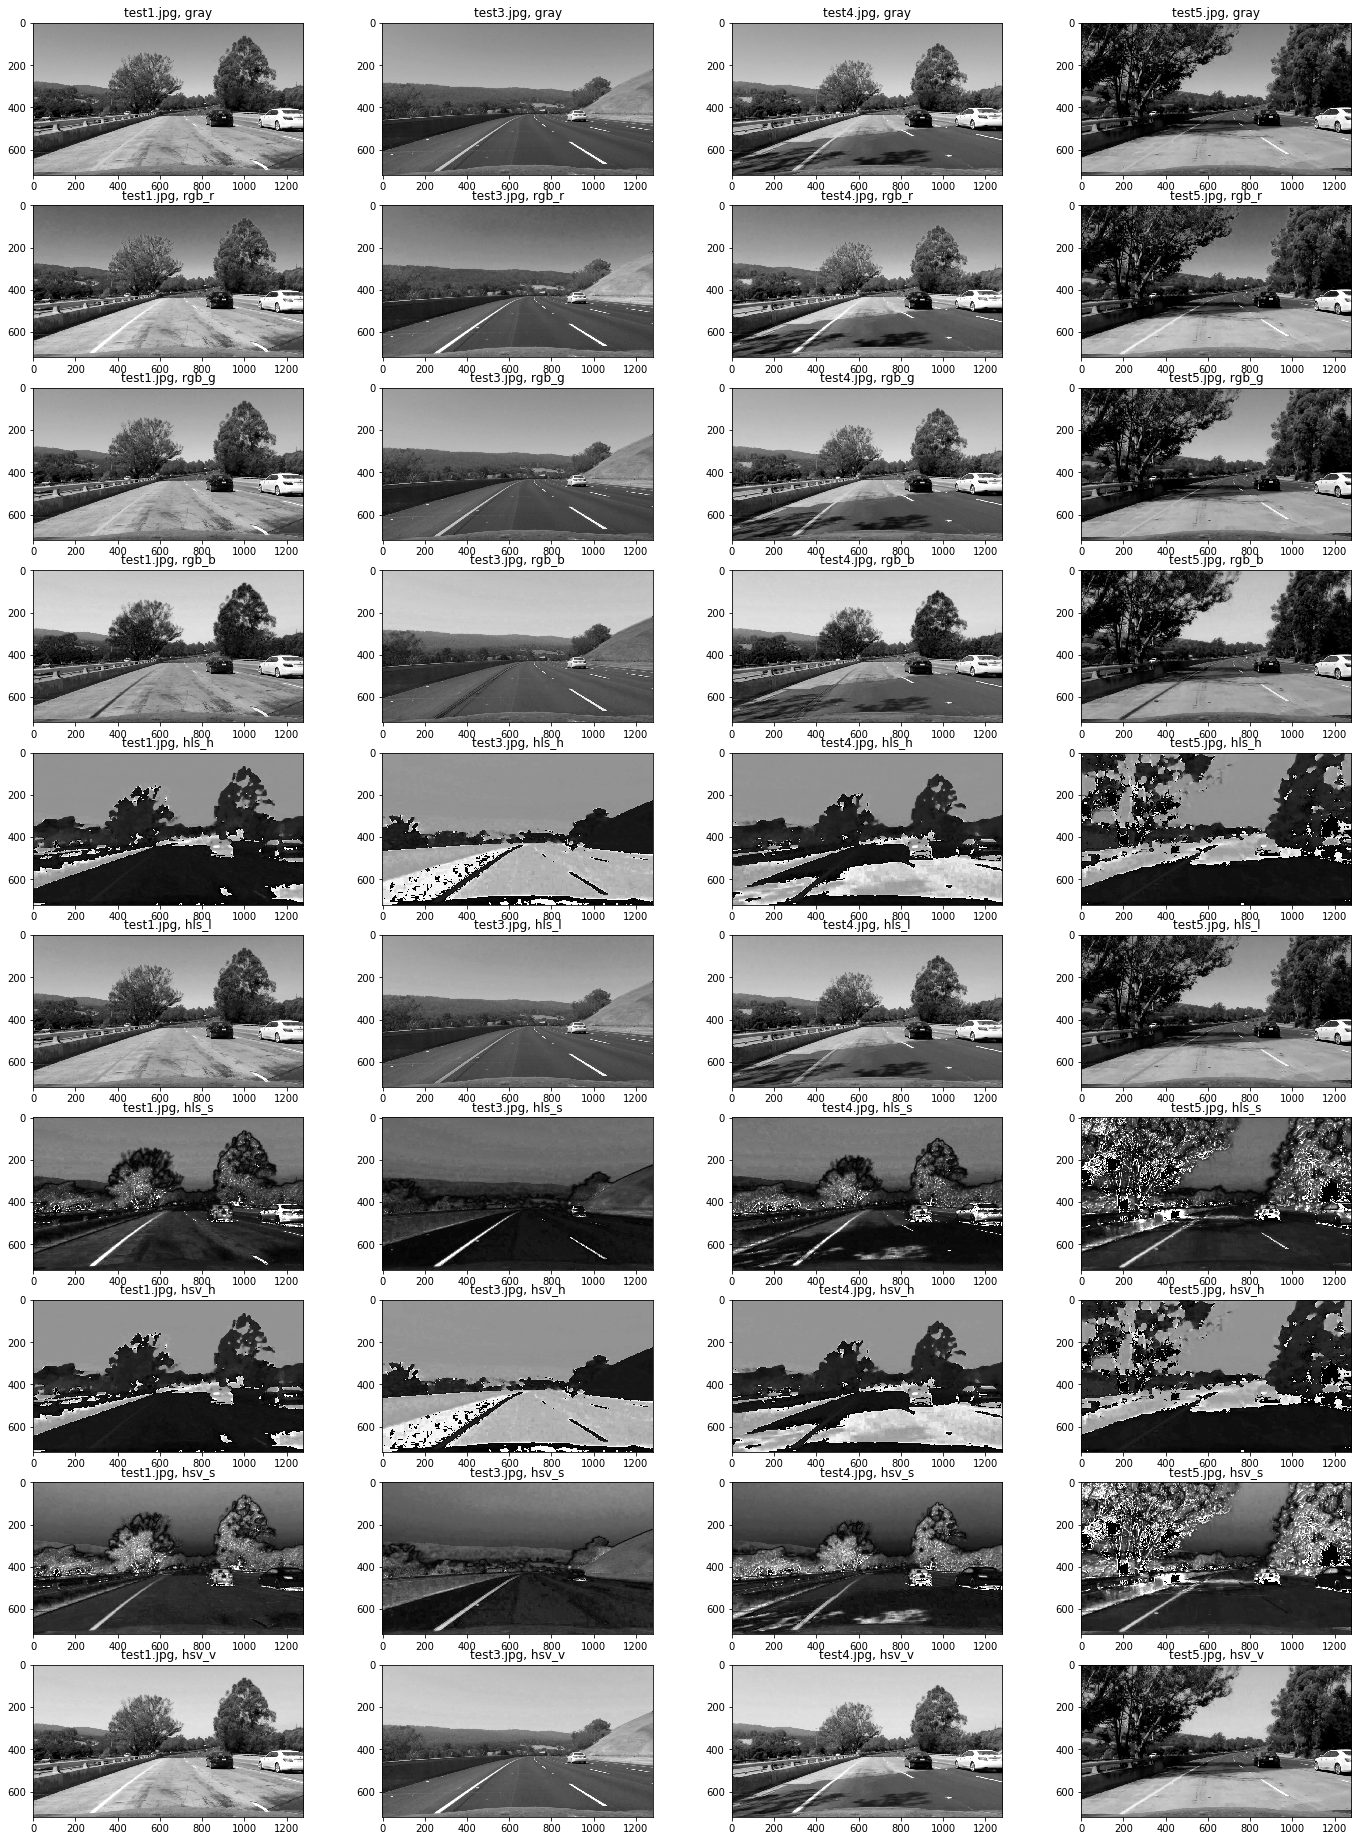

In [152]:
color_spaces = [
    'gray', 'rgb_r', 'rgb_g', 'rgb_b',
    'hls_h', 'hls_l', 'hls_s', 
    'hsv_h', 'hsv_s', 'hsv_v', 
]

img_test_samples = [
    "test_images/test1.jpg",
    "test_images/test3.jpg",
    "test_images/test4.jpg",
    "test_images/test5.jpg"
]

nx = len(img_test_samples)
ny = len(color_spaces)

plt.figure(figsize=(24, 33))
for i, img_path in enumerate(img_test_samples):
    img = load_undistort_img(img_path)
    
    for j, cs in enumerate(color_spaces):        
        gray = utils.gray_conv(img, cs)
        ax = plt.subplot(ny, nx, nx*j + i + 1)
        ax.set_title("{0}, {1}".format(Path(img_path).name, cs))
        plt.imshow(gray, cmap='gray')

In [13]:
img_test = load_undistort_img("test_images/test5.jpg")

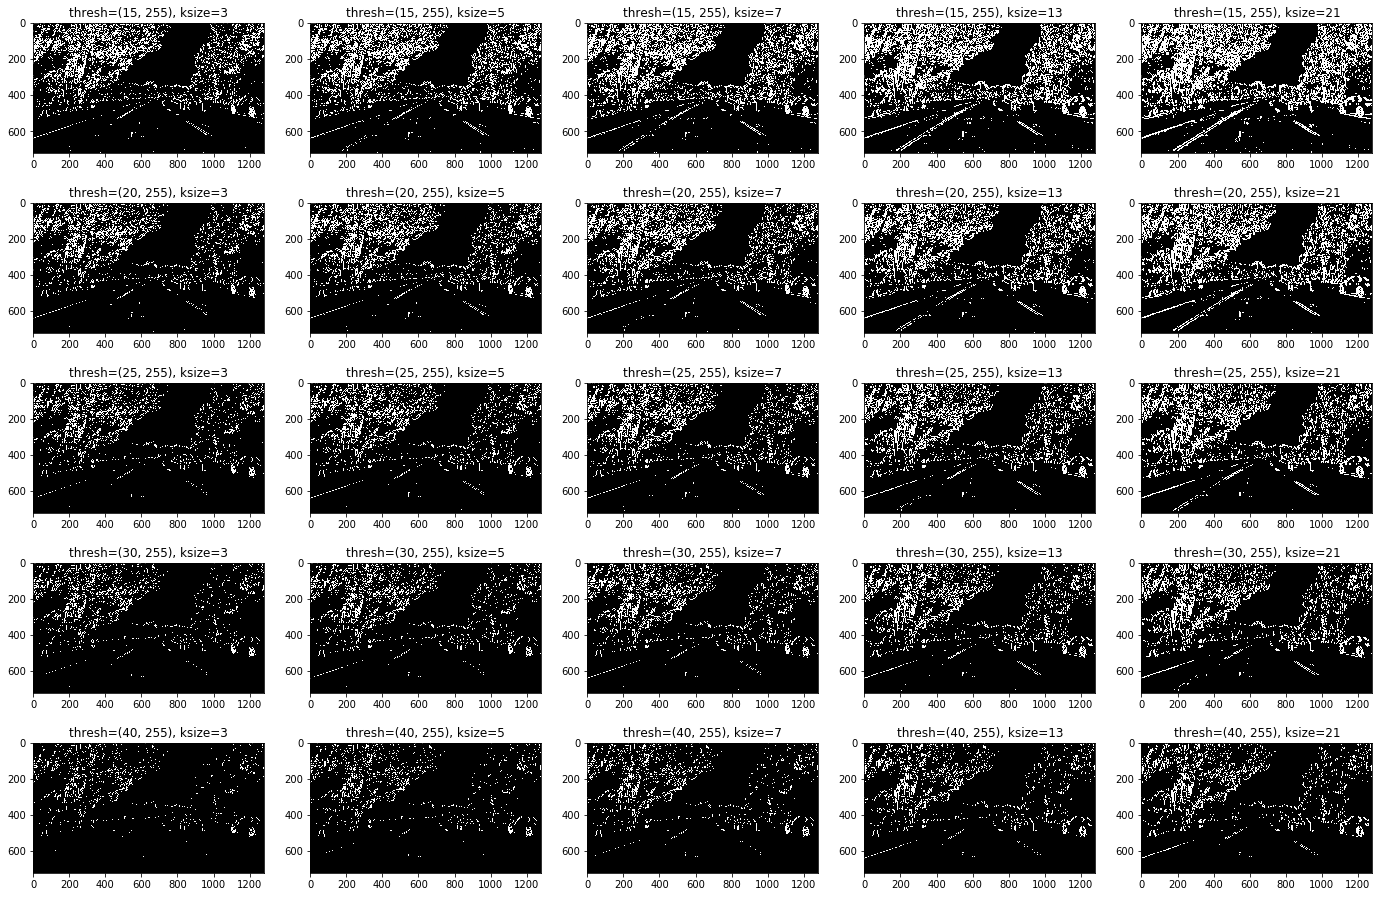

In [57]:
threshes = [(15, 255), (20, 255), (25, 255), (30, 255), (40, 255)]
ksizes = [3, 5, 7, 13, 21]
ny = len(threshes)
nx = len(ksizes)

plt.figure(figsize=(24, 16))
for i, thresh in enumerate(threshes):
    for j, ksize in enumerate(ksizes):
        ax = plt.subplot(ny, nx, nx*i + j + 1)
        res = utils.abs_sobel_thresh(img_test, 'x', sobel_kernel=ksize, thresh=thresh, color_space='rgb_r')
        ax.set_title("thresh={0}, ksize={1}".format(thresh, ksize))
        plt.imshow(res, cmap='gray')

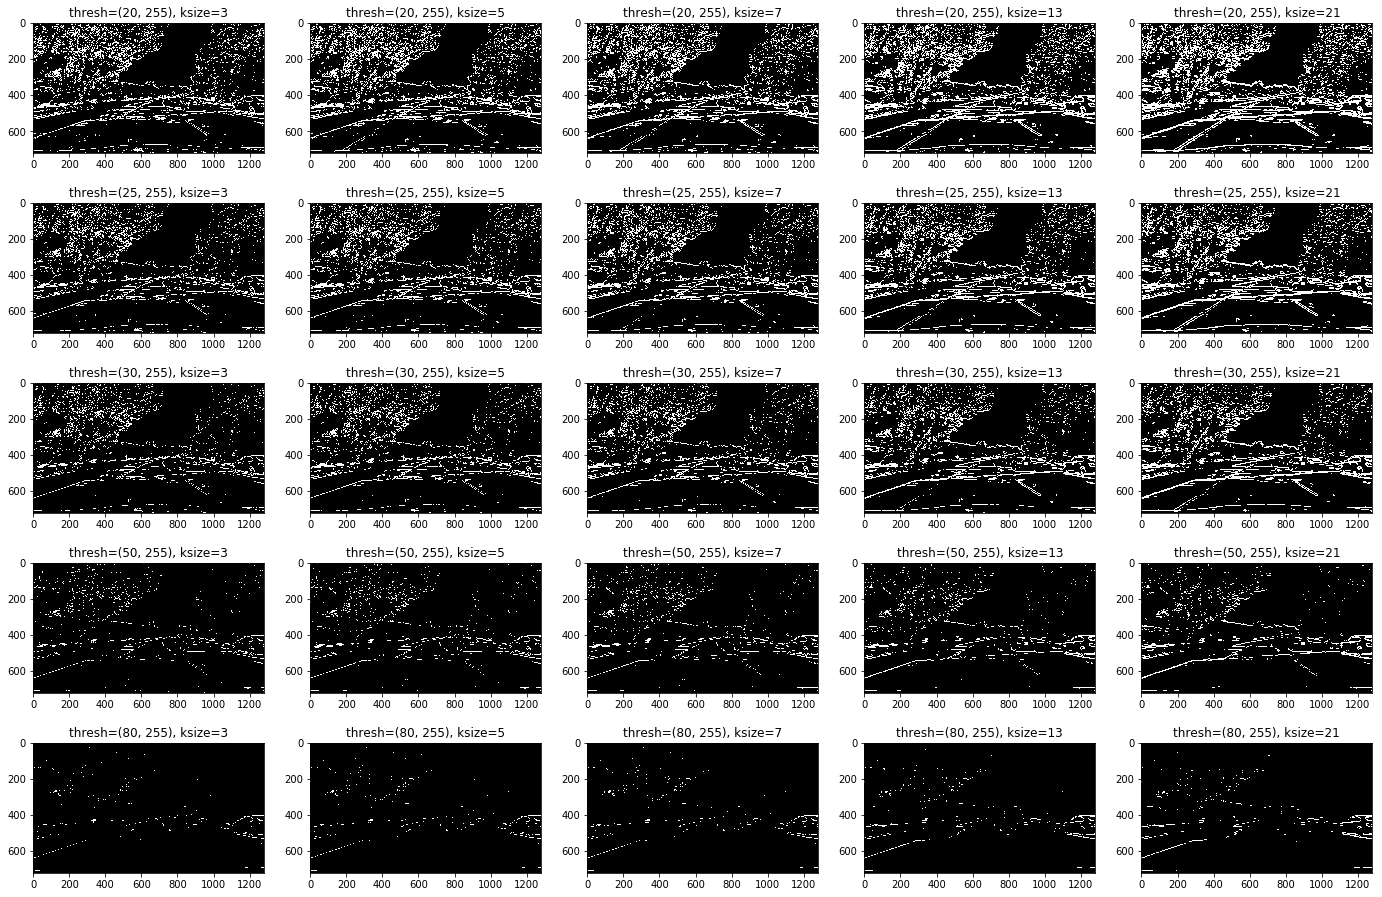

In [58]:
threshes = [(20, 255), (25, 255), (30, 255), (50, 255), (80, 255)]
ksizes = [3, 5, 7, 13, 21]
ny = len(threshes)
nx = len(ksizes)

plt.figure(figsize=(24, 16))
for i, thresh in enumerate(threshes):
    for j, ksize in enumerate(ksizes):
        ax = plt.subplot(ny, nx, nx*i + j + 1)
        res = utils.abs_sobel_thresh(img_test, 'y', sobel_kernel=ksize, thresh=thresh, color_space='rgb_r')
        ax.set_title("thresh={0}, ksize={1}".format(thresh, ksize))
        plt.imshow(res, cmap='gray')

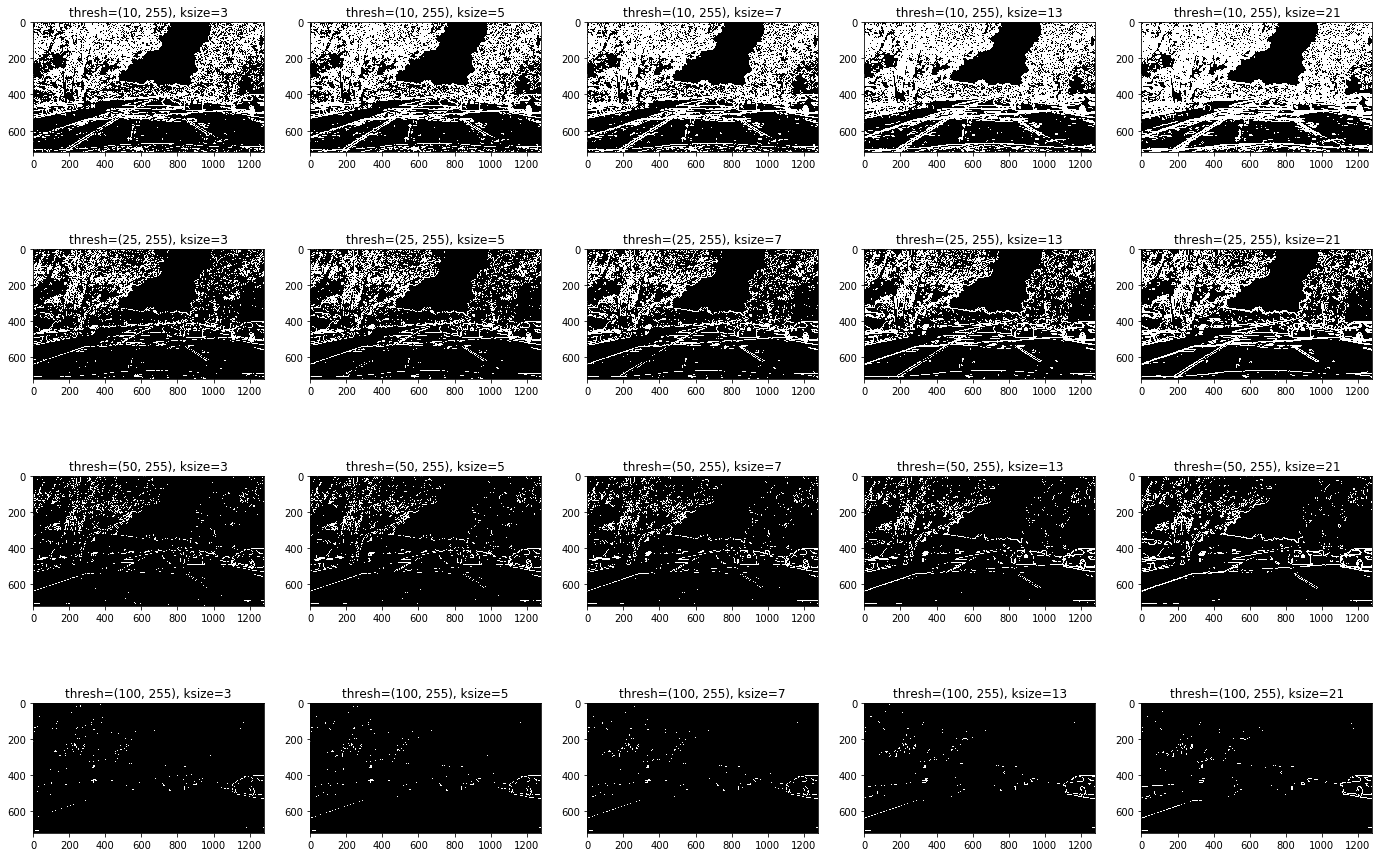

In [59]:
threshes = [(10, 255), (25, 255), (50, 255), (100, 255), ]
ksizes = [3, 5, 7, 13, 21]
ny = len(threshes)
nx = len(ksizes)

plt.figure(figsize=(24, 16))
for i, thresh in enumerate(threshes):
    for j, ksize in enumerate(ksizes):
        ax = plt.subplot(ny, nx, nx*i + j + 1)
        res = utils.mag_thresh(img_test, sobel_kernel=ksize, mag_thresh=thresh, color_space='rgb_r')
        ax.set_title("thresh={0}, ksize={1}".format(thresh, ksize))
        plt.imshow(res, cmap='gray')

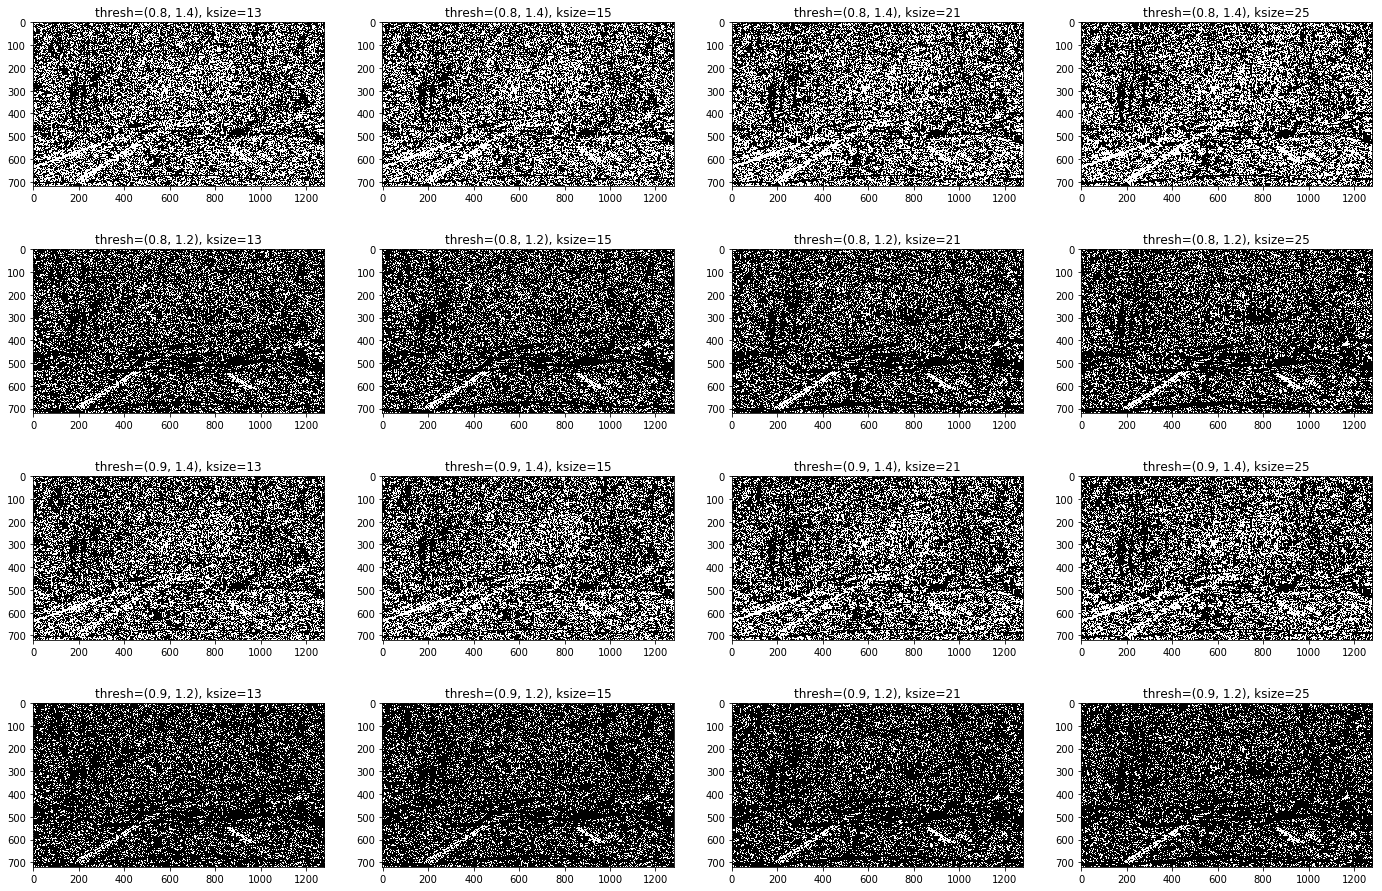

In [60]:
threshes = [(0.8, 1.4), (0.8, 1.2), (0.9, 1.4), (0.9, 1.2)]
ksizes = [13, 15, 21, 25]
ny = len(threshes)
nx = len(ksizes)

plt.figure(figsize=(24, 16))
for i, thresh in enumerate(threshes):
    for j, ksize in enumerate(ksizes):
        ax = plt.subplot(ny, nx, nx*i + j + 1)
        res = utils.dir_thresh(img_test, sobel_kernel=ksize, dir_thresh=thresh, color_space='rgb_r')
        ax.set_title("thresh={0}, ksize={1}".format(thresh, ksize))
        plt.imshow(res, cmap='gray')

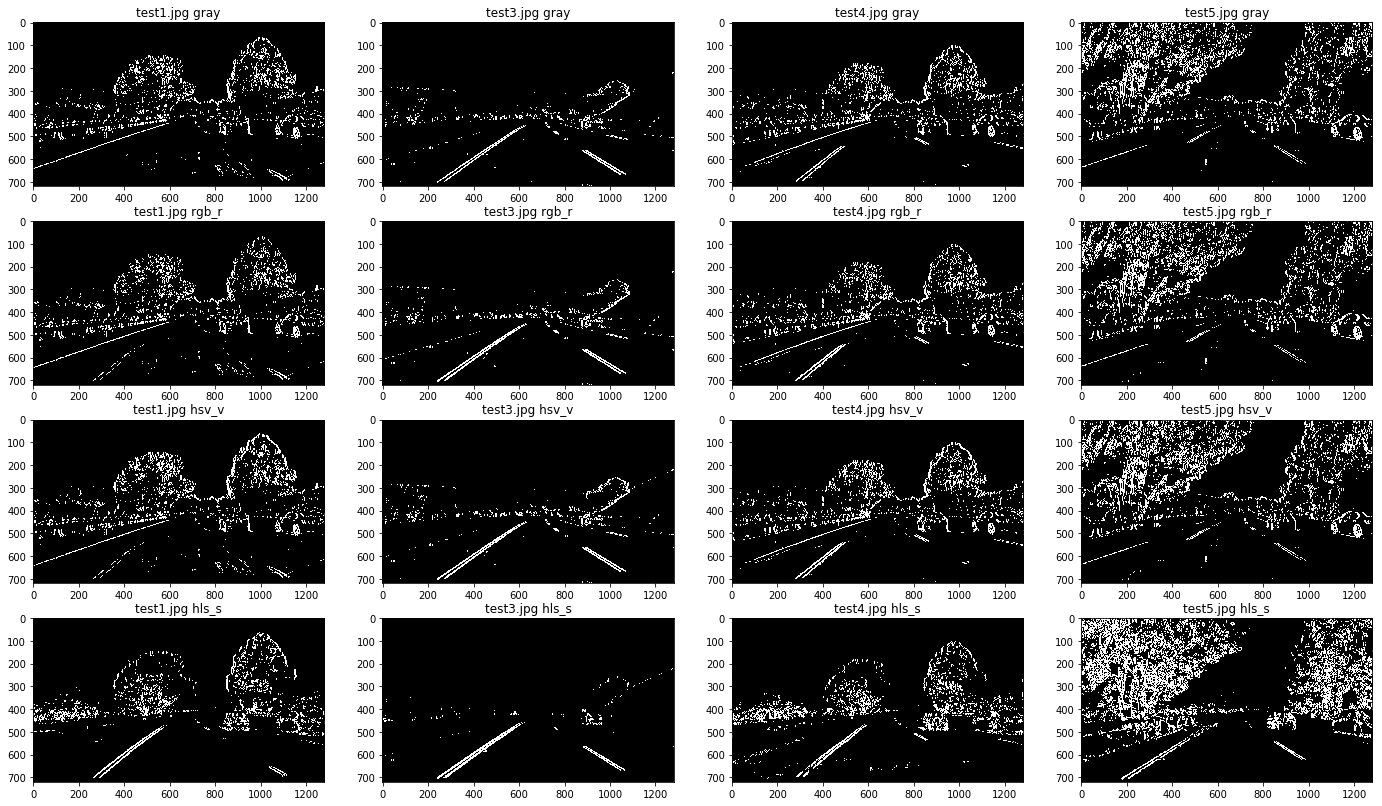

In [61]:
color_spaces = ['gray', 'rgb_r', 'hsv_v', 'hls_s']
ny = len(color_spaces)
nx=len(img_test_samples)

ksize = 13
thresh = (30, 255)

plt.figure(figsize=(24, 14))
for i, img_path in enumerate(img_test_samples):
    img = load_undistort_img(img_path)
    for j, cs in enumerate(color_spaces):
        ax = plt.subplot(ny, nx, nx*j + i + 1)
        res = utils.abs_sobel_thresh(img, 'x', sobel_kernel=ksize, thresh=thresh, color_space=cs)
        ax.set_title("{0} {1}".format(Path(img_path).name,  cs))
        plt.imshow(res, cmap='gray')

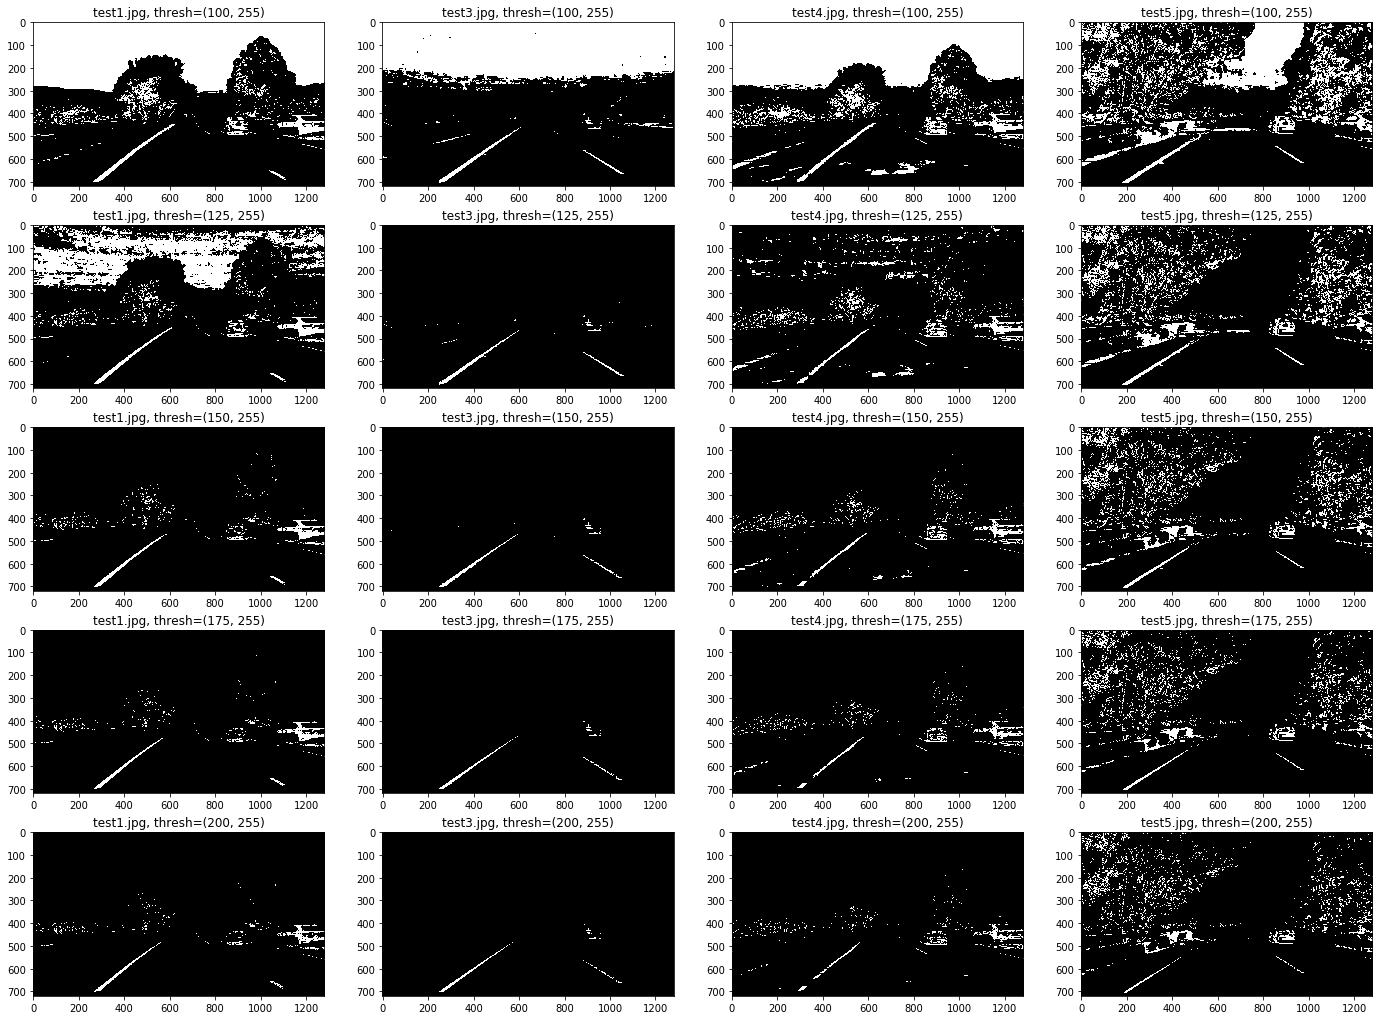

In [183]:
threshes = [(100, 255), (125, 255), (150, 255), (175, 255), (200, 255)]
ny = len(threshes)
nx=len(img_test_samples)

plt.figure(figsize=(24, 18))
for i, img_path in enumerate(img_test_samples):
    img = load_undistort_img(img_path)
    
    for j, thresh in enumerate(threshes):        
        ax = plt.subplot(ny, nx, nx*j + i + 1)
        res = utils.color_channel_thresh(img, thresh=thresh, color_space='hls_s')
        ax.set_title("{0}, thresh={1}".format(Path(img_path).name, thresh))
        plt.imshow(res, cmap='gray')

In [195]:
def combined_binary(img):
    channel_thresh = (150, 255)
    thresh = (25, 255)
    ksize = 13
    ch_binary = utils.color_channel_thresh(img, thresh=channel_thresh, color_space='hls_s')    
    binary = utils.abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh, color_space='rgb_r')

    cl_binary = np.dstack(( np.zeros_like(binary), binary, ch_binary)) * 255
    cb_binary = np.zeros_like(ch_binary)
    cb_binary[(ch_binary == 1) | ((binary == 1))] = 1
    return ch_binary, cl_binary

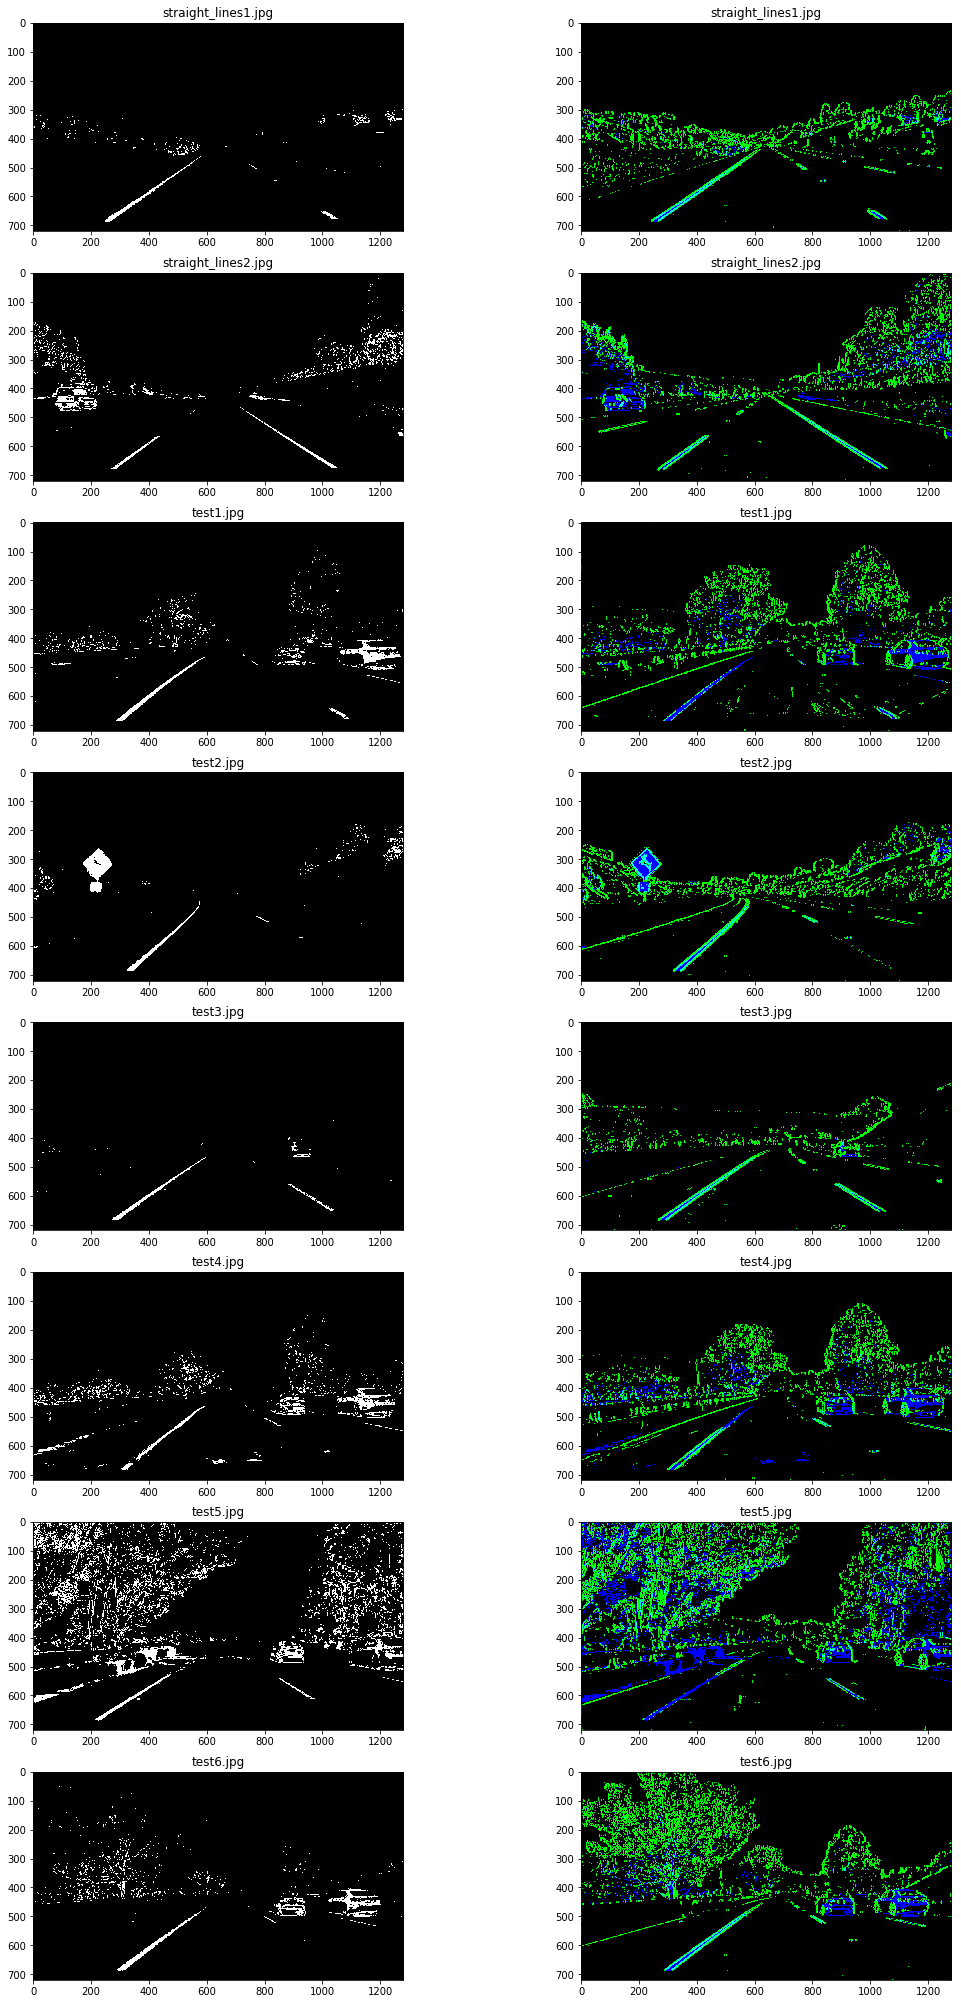

In [196]:
ny = len(img_tests)
nx = 2

plt.figure(figsize=(18,36))
for i, img_path in enumerate(img_tests):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        cb_binary, cl_binary = combined_binary(img)
        
        ax = plt.subplot(ny, nx, 2*i + 1)
        ax.set_title("{0}".format(Path(img_path).name))
        plt.imshow(cb_binary, cmap='gray')
        
        ax = plt.subplot(ny, nx, 2*i + 2)
        ax.set_title("{0}".format(Path(img_path).name))
        plt.imshow(cl_binary)


## Combines Perspective Transform and Binarization

Here, I will apply two preprocessing, Perspective Transformation and Image Binalization.


In [73]:
def perspective_and_binarize(img_path, M):
    img_undistort = load_undistort_img(img_path=img_path)
    img_binary, _ = combined_binary(img_undistort)
    img_warped = utils.warp_img(img_binary, M)
    return img_undistort, img_binary, img_warped

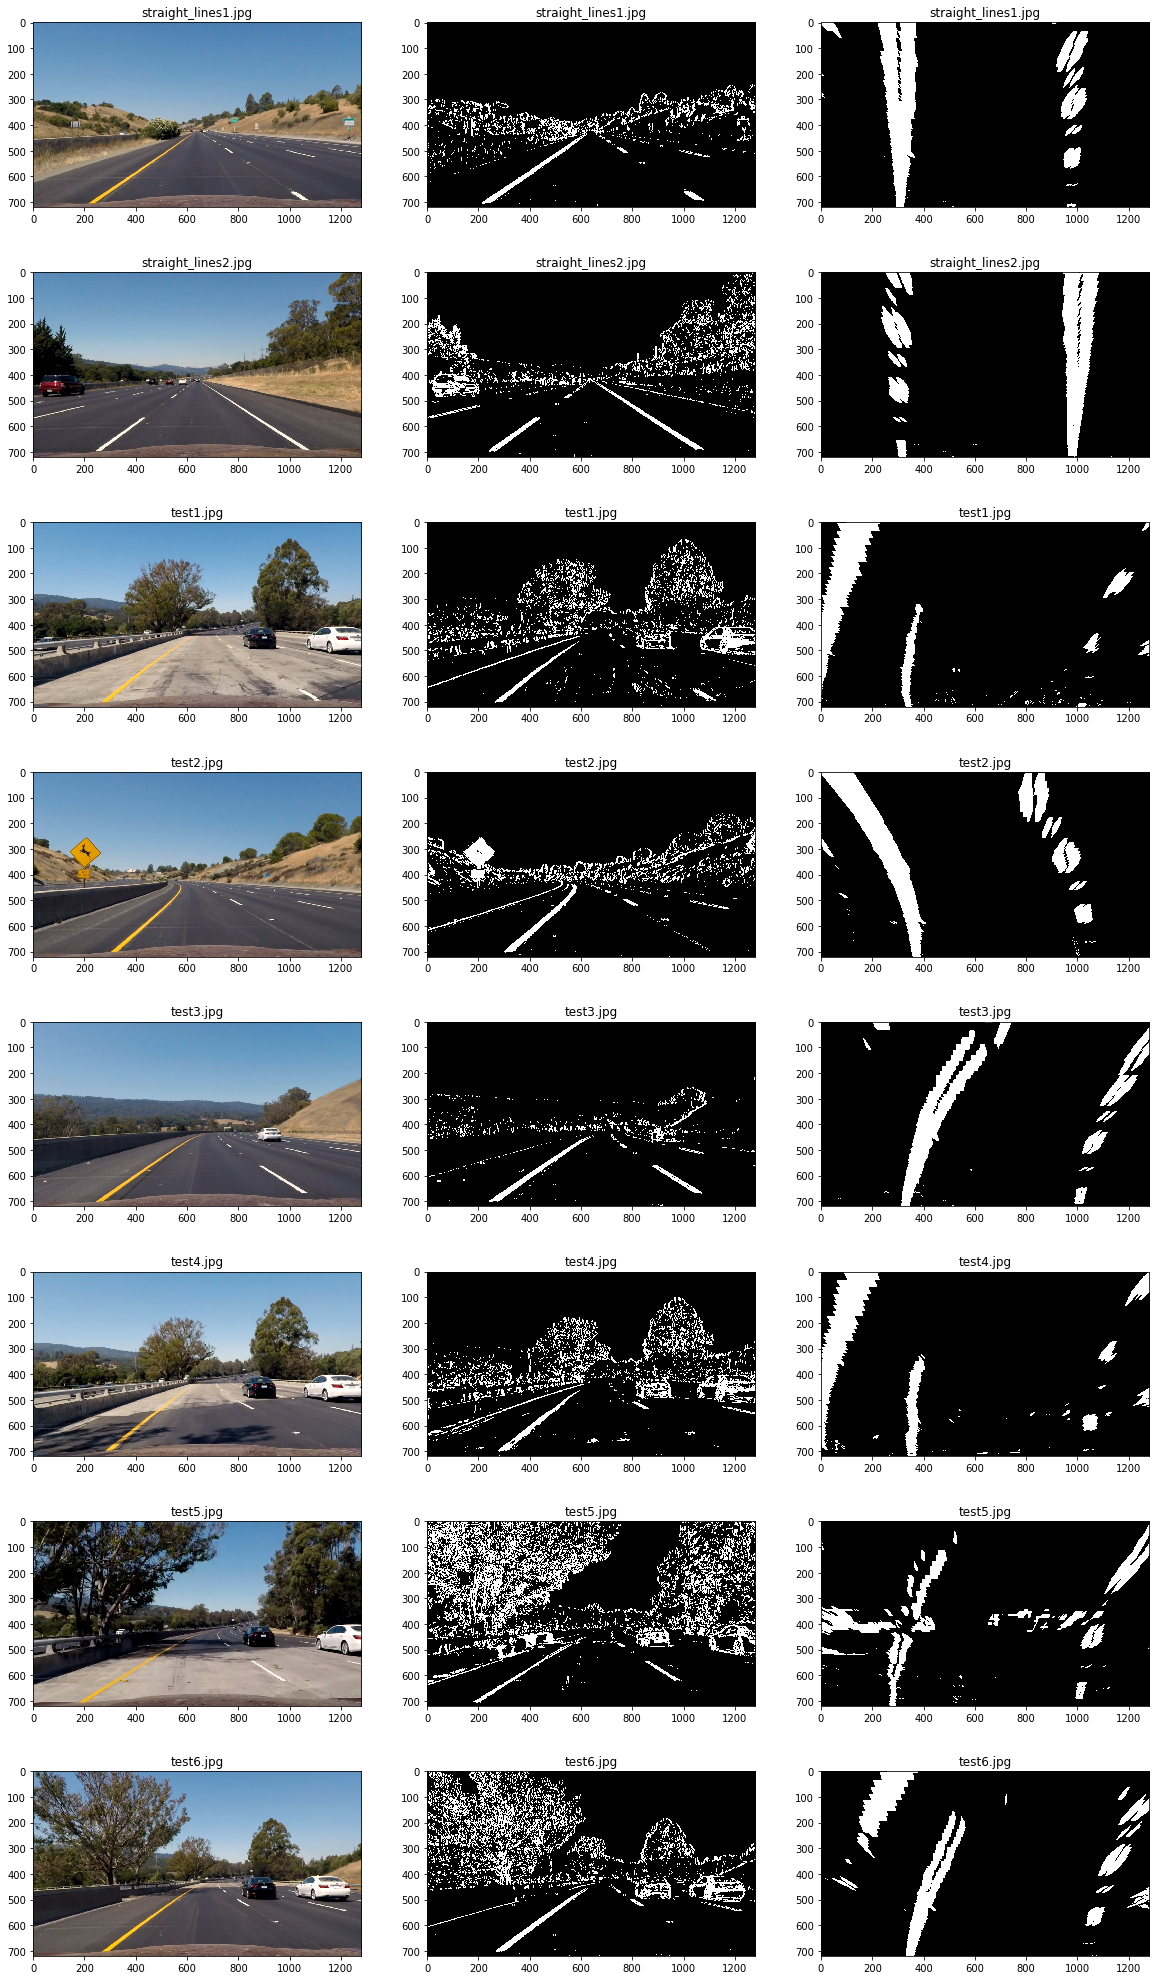

In [74]:
ny = len(img_tests)
nx = 3

plt.figure(figsize=(20,36))
for i, img_path in enumerate(img_tests):
    img_undistort, img_binary, img_warped = perspective_and_binarize(img_path, M)
    
    ax = plt.subplot(ny, nx, nx*i + 1)
    ax.set_title("{0}".format(Path(img_path).name))
    plt.imshow(img_undistort, cmap='gray')

    ax = plt.subplot(ny, nx, nx*i + 2)
    ax.set_title("{0}".format(Path(img_path).name))
    plt.imshow(img_binary, cmap='gray')

    ax = plt.subplot(ny, nx, nx*i + 3)
    ax.set_title("{0}".format(Path(img_path).name))
    plt.imshow(img_warped, cmap='gray')
    

## Polynomial Fit

In [67]:
import matplotlib.gridspec as gridspec

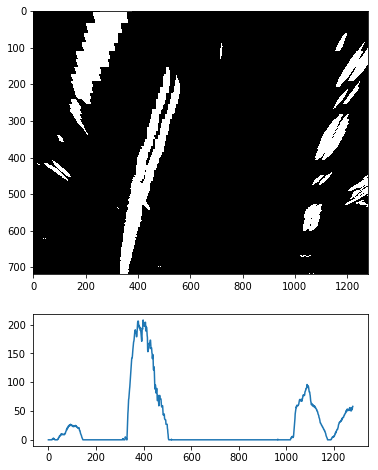

In [68]:
_, _, binary_warped = perspective_and_binarize("test_images/test5.jpg", src_points)
histogram = np.sum(img_warped[img_warped.shape[0]//2:, :], axis=0)

plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
plt.imshow(img_warped, cmap='gray', aspect="auto")
ax2 = plt.subplot(gs[1])
plt.plot(histogram)

(720, 0)

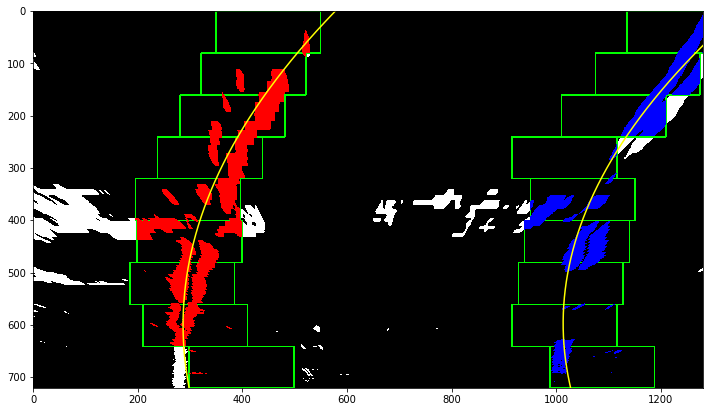

In [199]:
fit_res = fit_lane(binary_warped)
left_fit = fit_res["left_fit"]
right_fit = fit_res["right_fit"]
out_img = fit_res["out_img"]
nonzerox = fit_res["nonzerox"] 
nonzeroy = fit_res["nonzeroy"]
left_lane_inds = fit_res["left_lane_inds"]
right_lane_inds = fit_res["right_lane_inds"]

# Generate x and y values for plotting
plt.figure(figsize=(12, 8))
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

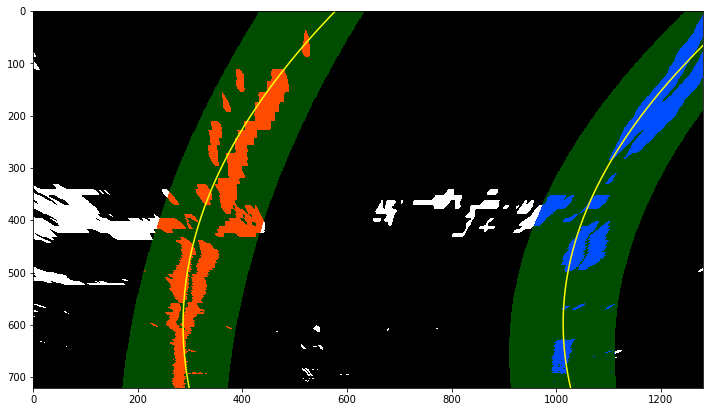

In [220]:
fit_res = utils.update_fit_lane(binary_warped, fit_res)
left_fit = fit_res["left_fit"]
right_fit = fit_res["right_fit"]
out_img = fit_res["out_img"]

plt.figure(figsize=(12, 8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Measturing curvature

In [88]:
# get evaluation point
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_curverad, right_curverad = utils.measure_curvature(y_eval, fit_res, xm_per_pix, ym_per_pix)
print("{0:.1f}m {1:.1f}m".format(left_curverad, right_curverad))

400.9m 204.5m


## Sliding window

In [ ]:
# Read in a thresholded image

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results    

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()